In [1]:
import os
import glob
import torch
import librosa
from torchvision import transforms, datasets
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn

import matplotlib.pyplot as plt
import scipy
import wave
import numpy as np
LENGTH = 2 * 6145

In [2]:
on_fname = glob.glob('./data/train/on/*.wav')[0]
off_fname = glob.glob('./data/train/off/*.wav')[0]
    
on_sample = librosa.load(on_fname, 44000)[0]
off_sample = librosa.load(off_fname, 44000)[0]

In [3]:
def fft_buffer(x):
    window = np.hanning(x.shape[0])

    # Calculate FFT
    fx = np.fft.rfft(window * x)

    # Convert to normalised PSD
    Pxx = abs(fx)**2 / (np.abs(window)**2).sum()

    # Scale for one-sided (excluding DC and Nyquist frequencies)
    Pxx[1:-1] *= 2

    # And scale by frequency to get a result in (dB/Hz)
    # Pxx /= Fs
    return Pxx ** 0.5

def randomCrop(sample):
    idx = np.random.randint(0, len(sample) - LENGTH)
    return sample[idx:idx+LENGTH]
    
def DataLoader():
    while True:
        x_on = torch.FloatTensor(fft_buffer(randomCrop(on_sample)))
        x_off = torch.FloatTensor(fft_buffer(randomCrop(off_sample)))
        x = Variable(torch.stack([x_on, x_off]))
        y = Variable(torch.FloatTensor([[1], [0]]))
        yield x, y

In [4]:
P = nn.Sequential(
    nn.Linear(in_features=LENGTH // 2 + 1, out_features=1, bias=True),
    nn.Sigmoid()
)

loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(P.parameters(), weight_decay=1e-4)

In [5]:
iters = 5000
for i, (x, y) in enumerate(DataLoader()):
    
    optimizer.zero_grad()
    pred = P(x)
    loss = loss_function(pred, y)
    loss.backward()
    optimizer.step()
    if i % (iters // 10) == 0:
        print('[%05d/%05d] binary cross-entropy loss: %2.4f'%(i, iters, loss.data.tolist()[0]))
    
    if i > iters:
        break

[00000/05000] binary cross-entropy loss: 0.7002
[00500/05000] binary cross-entropy loss: 0.4782
[01000/05000] binary cross-entropy loss: 0.2747
[01500/05000] binary cross-entropy loss: 0.1776
[02000/05000] binary cross-entropy loss: 0.0427
[02500/05000] binary cross-entropy loss: 0.0756
[03000/05000] binary cross-entropy loss: 0.2070
[03500/05000] binary cross-entropy loss: 0.0351
[04000/05000] binary cross-entropy loss: 0.0980
[04500/05000] binary cross-entropy loss: 0.0840
[05000/05000] binary cross-entropy loss: 0.0586


In [6]:
loss.data.tolist()[0]

0.05352899804711342

In [7]:
pred

Variable containing:
 0.9561
 0.0603
[torch.FloatTensor of size 2x1]

In [8]:
w = list(P.parameters())[0].data.numpy()[0, :-1]
b = list(P.parameters())[1].data.numpy()

In [9]:
w.shape

(6145,)

In [10]:
np.savez('pretrained', w=w, b=b)

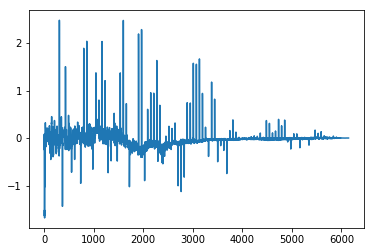

In [12]:
%matplotlib inline
plt.plot(w.T)

In [13]:
#!/usr/bin/env python
from __future__ import division

from pyqtgraph.Qt import QtGui, QtCore
import numpy as np
from scipy.signal import filtfilt
from numpy import nonzero, diff

import pyqtgraph as pg
from recorder import SoundCardDataSource
w = np.load('pretrained.npz')['w']
b = np.load('pretrained.npz')['b']

act_limit=3
pg.setConfigOption('background', 'w')
# Based on function from numpy 1.8
def rfftfreq(n, d=1.0):
    """
    Return the Discrete Fourier Transform sample frequencies
    (for usage with rfft, irfft).

    The returned float array `f` contains the frequency bin centers in cycles
    per unit of the sample spacing (with zero at the start). For instance, if
    the sample spacing is in seconds, then the frequency unit is cycles/second.

    Given a window length `n` and a sample spacing `d`::

    f = [0, 1, ..., n/2-1, n/2] / (d*n) if n is even
    f = [0, 1, ..., (n-1)/2-1, (n-1)/2] / (d*n) if n is odd

    Unlike `fftfreq` (but like `scipy.fftpack.rfftfreq`)
    the Nyquist frequency component is considered to be positive.

    Parameters
    ----------
    n : int
    Window length.
    d : scalar, optional
    Sample spacing (inverse of the sampling rate). Defaults to 1.

    Returns
    -------
    f : ndarray
    Array of length ``n//2 + 1`` containing the sample frequencies.
    """
    if not isinstance(n, int):
        raise ValueError("n should be an integer")
    val = 1.0/(n*d)
    N = n//2 + 1
    results = np.arange(0, N, dtype=int)
    return results * val


def fft_slices(x):
    Nslices, Npts = x.shape
    window = np.hanning(Npts)

    # Calculate FFT
    fx = np.fft.rfft(window[np.newaxis, :] * x, axis=1)

    # Convert to normalised PSD
    Pxx = abs(fx)**2 / (np.abs(window)**2).sum()

    # Scale for one-sided (excluding DC and Nyquist frequencies)
    Pxx[:, 1:-1] *= 2

    # And scale by frequency to get a result in (dB/Hz)
    # Pxx /= Fs
    return Pxx ** 0.5


def find_peaks(Pxx):
    # filter parameters
    b, a = [0.01], [1, -0.99]
    Pxx_smooth = filtfilt(b, a, abs(Pxx))
    peakedness = abs(Pxx) / Pxx_smooth

    # find peaky regions which are separated by more than 10 samples
    peaky_regions = nonzero(peakedness > 1)[0]
    edge_indices = nonzero(diff(peaky_regions) > 10)[0]  # RH edges of peaks
    edges = [0] + [(peaky_regions[i] + 5) for i in edge_indices]
    if len(edges) < 2:
        edges += [len(Pxx) - 1]

    peaks = []
    for i in range(len(edges) - 1):
        j, k = edges[i], edges[i+1]
        peaks.append(j + np.argmax(peakedness[j:k]))
    return peaks


def fft_buffer(x):
    window = np.hanning(x.shape[0])

    # Calculate FFT
    fx = np.fft.rfft(window * x)

    # Convert to normalised PSD
    Pxx = abs(fx)**2 / (np.abs(window)**2).sum()

    # Scale for one-sided (excluding DC and Nyquist frequencies)
    Pxx[1:-1] *= 2

    # And scale by frequency to get a result in (dB/Hz)
    # Pxx /= Fs
    return Pxx ** 0.5


class LiveFFTWindow(pg.GraphicsWindow):
    def __init__(self, recorder):
        super(LiveFFTWindow, self).__init__(title="Live FFT")
        self.recorder = recorder
        self.paused = False
        self.logScale = False
        self.showPeaks = False
        self.downsample = True

        # Setup plots
        self.p1 = self.addPlot()
        self.p1.setLabel('bottom', 'Time', 's')
        self.p1.setLabel('left', 'Amplitude')
        self.p1.setTitle("")
        self.ts = self.p1.plot(pen='b')
        self.nextRow()
        self.p2 = self.addPlot()
        self.p2.setLabel('bottom', 'Frequency', 'Hz')
        self.spec = self.p2.plot(pen=(0, 0, 200),
                                 brush=(0, 0, 200),
                                 fillLevel=-100)
        self.nextRow()
        self.p3 = self.addPlot()
        self.p3.setLabel('bottom', 'Frequency', 'Hz')
        self.p3.setLabel('left', 'Weight', '')
        self.p3.setTitle('Perceptron weights')
        self.weight = self.p3.plot(pen='b', brush='b')

        self.nextRow()
        self.p4 = self.addPlot()
        self.p4.setLabel('bottom', 'INPUT', '')
        self.p4.setLabel('left', 'OUTPUT', '')
        self.p4.setTitle('Activation')
        self.act = self.p4.plot(pen='b', brush='b')

        self.nextRow()
        self.p5 = self.addPlot()
        self.p5.setTitle('Non-Linearity')

        x = np.linspace(-act_limit, act_limit, 1000)
        y = np.tanh(x)
        self.p5.plot(pen='r', brush='r').setData(x=x, y=y)

        #notePen = pg.mkPen((220, 0, 50, 100))
        #self.act_line = self.p4.addLine(x=0, pen=notePen)

        '''
        # Show note lines
            A = 440.0
            notePen = pg.mkPen((0, 200, 50, 100))
            while A < (self.recorder.fs / 2):
                self.p2.addLine(x=A, pen=notePen)
                A *= 2
        '''

        # Lines for marking peaks
        self.peakMarkers = []

        # Data ranges
        self.resetRanges()

        # Timer to update plots
        self.timer = QtCore.QTimer()
        self.timer.timeout.connect(self.update)
        interval_ms = 1000 * (self.recorder.chunk_size / self.recorder.fs)
        #print ("Updating graphs every %.1f ms" % interval_ms)
        self.timer.start(interval_ms)

    def resetRanges(self):
        self.timeValues = self.recorder.timeValues
        self.freqValues = rfftfreq(len(self.timeValues),
                                   1./self.recorder.fs)

        self.p1.setRange(xRange=(0, self.timeValues[-1]), yRange=(-1, 1))
        if self.logScale:
            self.p2.setRange(xRange=(0, self.freqValues[-1]),
                             yRange=(-60, 20))
            self.spec.setData(fillLevel=-100)
            self.p2.setLabel('left', 'PSD', 'dB / Hz')
        else:
            self.p2.setRange(xRange=(0, self.freqValues[-1]),
                             yRange=(0, 50))
            self.spec.setData(fillLevel=0)
            self.p2.setLabel('left', 'PSD', '1 / Hz')

    def plotPeaks(self, Pxx):
        # find peaks bigger than a certain threshold
        peaks = [p for p in find_peaks(Pxx) if Pxx[p] > 0.3]

        if self.logScale:
            Pxx = 20*np.log10(Pxx)

        # Label peaks
        old = self.peakMarkers
        self.peakMarkers = []
        for p in peaks:
            if old:
                t = old.pop()
            else:
                t = pg.TextItem(color=(150, 150, 150, 150))
                self.p2.addItem(t)
            self.peakMarkers.append(t)
            t.setText("%.1f Hz" % self.freqValues[p])
            t.setPos(self.freqValues[p], Pxx[p])
        for t in old:
            self.p2.removeItem(t)
            del t

    def update(self):
        if self.paused:
            return
        data = self.recorder.get_buffer()
        weighting = np.exp(self.timeValues / self.timeValues[-1])
        Pxx = fft_buffer(weighting * data[:, 0])

        if self.downsample:
            downsample_args = dict(autoDownsample=False,
                                   downsampleMethod='subsample',
                                   downsample=10)
        else:
            downsample_args = dict(autoDownsample=True)

        self.ts.setData(x=self.timeValues, y=data[:, 0], **downsample_args)
        self.spec.setData(x=self.freqValues,
                          y=(20*np.log10(Pxx) if self.logScale else Pxx))

        pxx = (Pxx - Pxx.min()) 
        pxx /= pxx.max()
        # Show note lines


        notePen = pg.mkPen((0, 200, 50, 100))
        a = np.dot(w, Pxx) + b
        self.weight.setData(x=self.freqValues, y=w)
        print(a)
        a = max(-act_limit, min(a, act_limit))
        x = np.linspace(-act_limit, act_limit, len(w))
        y = np.tanh(x)
        A = np.ones(len(x))*0

        idx = (np.abs(x-a)).argmin()
        #print(idx)
        if idx == 0:
            A[5:15] = 1
        elif idx == len(A) - 1:
            A[-30:-10] = 1
        else:
            A[idx-10: idx+10] = 1
        self.act.setData(x=x, y=A)
        if self.showPeaks:
            self.plotPeaks(Pxx)

    def keyPressEvent(self, event):
        text = event.text()
        if text == " ":
            self.paused = not self.paused
            self.p1.setTitle("PAUSED" if self.paused else "")
        elif text == "l":
            self.logScale = not self.logScale
            self.resetRanges()
        elif text == "d":
            self.downsample = not self.downsample
        elif text == "+":
            self.recorder.num_chunks *= 2
            self.resetRanges()
        elif text == "-":
            self.recorder.num_chunks /= 2
            self.resetRanges()
        elif text == "p":
            self.showPeaks = not self.showPeaks
        else:
            super(LiveFFTWindow, self).keyPressEvent(event)


# Setup plots
#QtGui.QApplication.setGraphicsSystem('opengl')
app = QtGui.QApplication([])
#pg.setConfigOptions(antialias=True)

# Setup recorder
#FS = 12000
#FS = 22000
FS = 44000
recorder = SoundCardDataSource(num_chunks=3,
                               sampling_rate=FS,
                               chunk_size=4*1024)
win = LiveFFTWindow(recorder)

## Start Qt event loop unless running in interactive mode or using pyside.
if __name__ == '__main__':
    import sys
    if (sys.flags.interactive != 1) or not hasattr(QtCore, 'PYQT_VERSION'):
        QtGui.QApplication.instance().exec_()

[-3.30024958]
[-3.30024958]
[-2.68233776]
[-2.57076859]
[-2.57076859]
[-2.50227261]
[-2.79487991]
[-2.47369695]
[-2.47369695]
[-2.58758545]
[-2.58758545]
[-2.24539804]
[-2.26758122]
[-2.58190203]
[-2.58190203]
[-2.5867157]
[-2.5867157]
[-2.68655205]
[-2.68655205]
[-2.75580978]
[-2.75580978]
[-2.95805025]
[-2.45441031]
[-2.45441031]
[-3.26277828]
[ 0.74230742]
[ 0.74230742]
[-2.3812623]
[-2.60477972]
[-2.60477972]
[-3.67371583]
[-3.67371583]
[-4.24666548]
[-3.52464771]
[-3.52464771]
[-4.04626274]
[-3.56897092]
[-2.36982489]
[-2.36982489]
[-2.26256323]
[-2.41921282]
[-2.41921282]
[-2.57802749]
[-2.57802749]
[-2.38019037]
[-2.3947897]
[-2.3947897]
[-2.41744089]
[-2.59076333]
[-2.59076333]
[-2.63731194]
[-2.63731194]
[-2.63094187]
[-3.22504568]
[-3.86900973]
[-3.86900973]
[-3.40505767]
[ 0.20611227]
[ 0.20611227]
[-2.06699157]
[-2.24300313]
[-1.73395765]
[-1.73395765]
[-4.33057499]
[-4.07139206]
[-4.07139206]
[-3.69526863]
[-3.69526863]
[-4.31278419]
[-4.31278419]
[-3.33403444]
[-3.3340344

[-2.61345077]
[-2.61345077]
[-1.23898685]
[-1.23898685]
[-1.13149905]
[-1.13149905]
[-1.41883337]
[-1.23472488]
[-1.23472488]
[-0.75672114]
[-0.80584145]
[-0.88887912]
[-0.88887912]
[-0.77864397]
[-0.99615067]
[-0.95537126]
[-0.95537126]
[-0.52100122]
[-0.55144358]
[-0.55144358]
[-0.50377095]
[-0.78981805]
[-0.98396498]
[-0.98396498]
[-1.63120222]
[-1.63120222]
[-2.57025623]
[-2.66052127]
[-2.66052127]
[-3.79446268]
[-4.08460236]
[-4.08460236]
[-4.08527327]
[-3.70547175]
[-3.70547175]
[-2.80926824]
[-2.80926824]
[-6.07724905]
[-2.3084197]
[-3.094697]
[-3.094697]
[-1.41460407]
[-1.63811684]
[-1.63811684]
[-1.62289548]
[-1.50464535]
[-1.14622355]
[-1.14622355]
[-9.95409012]
[-4.41945839]
[-4.41945839]
[-4.2928772]
[-4.32514572]
[-4.5489502]
[-4.5489502]
[-4.30417585]
[-4.30417585]
[-4.28910637]
[-4.18440342]
[-4.18273592]
[-4.18273592]
[-4.21568108]
[-4.17542458]
[-4.17542458]
[-4.37451649]
[-4.37451649]
[-4.30960274]
[-4.31784725]
[-4.31784725]
[-4.16254997]
[-4.27043152]
[-4.27043152]


[-2.26513362]
[-2.19857597]
[-2.27402353]
[-2.27402353]
[-2.24527979]
[-2.40736675]
[-2.25421906]
[-2.25421906]
[-2.3229413]
[-2.22969174]
[-2.22969174]
[-2.29893827]
[-2.29893827]
[-2.08428335]
[-2.2874558]
[-2.37675047]
[-2.37675047]
[-2.28129077]
[-2.27556324]
[-2.27556324]
[-2.21324706]
[-2.81410122]
[-2.81410122]
[ 0.66302919]
[ 0.66302919]
[-3.34872627]
[-2.00761294]
[-2.00761294]
[-3.00158715]
[-0.92751509]
[-0.92751509]
[-1.62925494]
[-2.42099428]
[-1.63400471]
[-1.63400471]
[-1.75305271]
[-2.0867393]
[-2.0867393]
[-2.33038521]
[-2.0764904]
[-2.03180647]
[-2.03180647]
[-2.19465256]
[-2.19465256]
[-1.79745507]
[-2.28083754]
[-2.28083754]
[-2.15065742]
[-1.04721236]
[-1.04721236]
[-2.16479731]
[-2.16479731]
[-2.22294068]
[-2.33302712]
[-2.33302712]
[-2.2522428]
[-2.17985821]
[-2.09710217]
[-2.09710217]
[-2.14699268]
[-2.10651135]
[-2.10651135]
[-4.8306179]
[-4.8306179]
[-3.54830098]
[-3.54830098]
[-2.22422385]
[-2.22422385]
[-2.21535659]
[-1.66127658]
[-1.66127658]
[-2.22110987]


[-2.48616838]
[-2.03243089]
[-2.61458635]
[-2.51769018]
[-2.29063773]
[-2.29063773]
[-2.28028965]
[-2.28028965]
[-2.78032827]
[-3.16861582]
[-2.2885623]
[-2.2885623]
[-2.20351768]
[-2.17171669]
[-2.17171669]
[-2.70258093]
[-2.61191249]
[-2.61191249]
[-2.25850511]
[-2.25850511]
[-1.65735877]
[ 1.69670725]
[ 1.69670725]
[-0.99753463]
[ 0.04801881]
[ 0.04801881]
[-3.55921888]
[-3.57233453]
[-1.92190862]
[-1.92190862]
[-1.75486588]
[-2.24031305]
[-2.24031305]
[-1.27721381]
[-1.27721381]
[-2.04677701]
[-2.04677701]
[-2.14188933]
[-2.14188933]
[ 0.65339017]
[ 1.36628342]
[ 1.36628342]
[ 0.4454329]
[ 0.4454329]
[-0.93164766]
[-0.93164766]
[-2.15710497]
[-2.27673244]
[-2.10269976]
[-2.10269976]
[-2.09670663]
[ 3.8408041]
[ 3.8408041]
[-1.43039739]
[-2.5024507]
[-2.06969714]
[-2.06969714]
[-1.93742466]
[-1.92862558]
[-1.92862558]
[-1.01822114]
[-1.95185423]
[-2.40574074]
[-2.40574074]
[-2.10783768]
[-2.10783768]
[-2.11228514]
[-1.68838716]
[-1.96343994]
[-1.96343994]
[-1.8215493]
[-1.77672887]


[-2.28141665]
[-2.2461431]
[-2.19834399]
[-2.19834399]
[-2.55068445]
[-2.55068445]
[-2.38520932]
[-2.19031549]
[-2.19031549]
[-2.04213452]
[-2.06138468]
[-2.06138468]
[-2.14671016]
[-2.14671016]
[-2.29838133]
[-2.57766581]
[-2.57766581]
[-2.35194874]
[-2.25361824]
[-2.14016795]
[-2.14016795]
[-2.05367613]
[-2.06126976]
[-2.06126976]
[-2.10429215]
[-2.17998362]
[-2.17998362]
[-2.23964262]
[-2.23964262]
[-2.13004899]
[-2.20754623]
[-2.20754623]
[-2.12295961]
[-2.18286848]
[-2.18286848]
[-2.17044973]
[-2.17044973]
[-2.27584291]
[-2.20029831]
[-2.20029831]
[-2.21373558]
[-2.18615675]
[-2.18615675]
[-2.08216572]
[-2.08216572]
[-2.20033741]
[-2.3112936]
[-2.3112936]
[-2.44332242]
[-2.27825809]
[-2.30146122]
[-2.30146122]
[-2.18735266]
[-2.22684383]
[-2.22684383]
[-2.13147187]
[-2.1264143]
[-2.1264143]
[-2.18757844]
[-2.15029383]
[-2.15029383]
[-2.22789812]
[-2.1224637]
[-2.1224637]
[-2.11586022]
[-2.11586022]
[-2.05219173]
[-2.19532061]
[-2.19532061]
[-2.20443463]
[-2.20443463]
[-2.18584585]

[-2.90166759]
[-2.70143127]
[-3.12310791]
[-2.58836746]
[-2.58836746]
[-2.50055003]
[-2.50055003]
[-3.18583465]
[-3.04925489]
[-3.04925489]
[-0.42211604]
[-0.42211604]
[-2.37792444]
[-2.37792444]
[-2.4190855]
[-1.25211859]
[-1.25211859]
[-1.96945679]
[-3.04110813]
[-2.63085222]
[-2.63085222]
[-2.69592762]
[-2.43765545]
[-2.43765545]
[-1.91790032]
[-1.91790032]
[-2.21632481]
[-2.53357768]
[-2.53357768]
[-2.48694682]
[-2.36778212]
[-2.36778212]
[-2.71272612]
[-1.45228219]
[-1.45228219]
[-1.96553528]
[-2.39459014]
[-2.11157131]
[-2.11157131]
[-2.36427593]
[-2.36427593]
[-2.03870678]
[-2.13728142]
[-1.73381376]
[-1.73381376]
[-2.55804706]
[-2.38179922]
[-2.38179922]
[-2.3815546]
[-2.27890682]
[-2.26215768]
[-2.26215768]
[-2.45127273]
[-2.15467834]
[-2.15467834]
[-2.13324356]
[-2.13324356]
[-2.71929979]
[-2.19096708]
[-2.19096708]
[-2.31809306]
[-2.47383761]
[-2.47383761]
[-2.5966804]
[-2.42824173]
[-2.42824173]
[-2.36686659]
[-2.36686659]
[-2.54477882]
[-2.54477882]
[-2.61899352]
[-2.61899

[-3.49491119]
[-3.19674683]
[-3.19674683]
[-3.66456604]
[-3.66456604]
[-3.02683306]
[-2.63283777]
[-2.63283777]
[-3.11343575]
[-2.6673007]
[-2.6673007]
[-2.94001913]
[-2.12430382]
[-2.12430382]
[-2.26183438]
[-2.41704226]
[-2.49141884]
[-2.49141884]
[-2.77444458]
[-2.77444458]
[-2.65340614]
[-2.27321053]
[-2.3108325]
[-2.3108325]
[-2.33639193]
[-2.35563183]
[-2.35563183]
[-2.26917362]
[-2.34499788]
[-2.34499788]
[-2.11893415]
[-2.11893415]
[-2.49055481]
[-1.25628138]
[-1.25628138]
[-2.43955278]
[-2.4948504]
[-2.4948504]
[-2.03098822]
[-2.03098822]
[-1.78900218]
[-1.78900218]
[-2.55808258]
[-2.55808258]
[-2.2906692]
[-2.31955147]
[-2.31955147]
[-2.32331204]
[-2.32331204]
[-0.45667851]
[-0.45667851]
[-0.46975684]
[ 5.39207458]
[ 5.39207458]
[-0.83639842]
[-1.99959874]
[-1.99959874]
[-2.34203124]
[-2.34203124]
[-2.62253904]
[-2.19295168]
[-2.19295168]
[-2.11439323]
[-1.30421937]
[-1.30421937]
[-2.18404603]
[-2.76179075]
[-2.04784727]
[-0.87607378]
[-2.24382424]
[-2.24382424]
[-2.25653219]

[-2.09911513]
[-2.09911513]
[-1.13306248]
[-1.48866868]
[-2.26433444]
[-2.26433444]
[-2.11739588]
[-2.11739588]
[-2.00943851]
[-2.2845211]
[-2.2845211]
[-2.76360559]
[-2.76360559]
[-2.10557938]
[-1.81704032]
[-1.81704032]
[-2.06379604]
[-2.1118536]
[-2.1118536]
[-2.06870794]
[-2.22883511]
[-2.22883511]
[-2.30106831]
[-2.30106831]
[-1.72069991]
[-1.92872393]
[-2.07072592]
[-2.07072592]
[-2.17174816]
[-2.09704614]
[-2.09704614]
[-1.67392337]
[-1.99564409]
[-1.89195585]
[-1.89195585]
[-1.88877082]
[-2.0217557]
[-2.0217557]
[-2.05325413]
[-2.45113397]
[-2.2500174]
[-2.2500174]
[-2.22564626]
[-2.33351445]
[-2.33351445]
[-2.38731241]
[-2.38731241]
[-2.27015257]
[-2.330441]
[-2.2833519]
[-2.2833519]
[-0.90324301]
[-0.90324301]
[-0.70372397]
[-0.70372397]
[-1.95539594]
[ 1.99472427]
[ 1.99472427]
[-1.4339875]
[-1.90007067]
[-2.35917854]
[-2.35917854]
[-2.20604205]
[-1.98912168]
[-1.98912168]
[-2.22250295]
[-2.22250295]
[-2.609025]
[-2.33052921]
[-2.33052921]
[-2.22655034]
[-0.32655954]
[-0.326

[-1.99732149]
[-1.99732149]
[-2.18112659]
[-2.23946834]
[-2.25309992]
[-2.25309992]
[-2.24836349]
[-2.18089437]
[-2.18089437]
[-2.24133492]
[-2.2695508]
[-2.2695508]
[-2.83138037]
[-2.83138037]
[-3.01424456]
[-2.7791152]
[-2.7791152]
[-2.54842448]
[-2.54842448]
[-2.34154224]
[-2.32449579]
[-2.32449579]
[-2.26874495]
[-2.26874495]
[-2.1107378]
[-2.1107378]
[-2.52508807]
[-2.52369976]
[-2.52369976]
[-2.40067649]
[-2.22975183]
[-2.44477749]
[-2.44477749]
[-2.62496042]
[-2.39017344]
[-2.39017344]
[-2.45939159]
[-2.58178544]
[-2.39499474]
[-2.39499474]
[-2.54384232]
[-2.72590518]
[-2.72590518]
[-2.66335869]
[-2.66335869]
[-2.35694075]
[-2.38776326]
[-2.38776326]
[-2.56038833]
[-2.56038833]
[-2.54420757]
[-2.58466339]
[-2.58466339]
[-2.3104279]
[-2.36033487]
[-2.58113194]
[-2.58113194]
[-2.38327789]
[-2.43000388]
[-2.43000388]
[-2.59261656]
[-2.47211194]
[-2.42541385]
[-2.42541385]
[-2.25972581]
[-2.45866156]
[-2.45866156]
[-2.30749559]
[-2.30749559]
[-2.23045826]
[-2.23045826]
[-2.22982597]

[-2.15865731]
[-2.2286849]
[-2.09757948]
[-2.14443111]
[-2.14443111]
[-2.32758403]
[-1.89119089]
[-1.89119089]
[-0.34421813]
[-0.21870017]
[-1.35628176]
[-1.35628176]
[-2.41311955]
[-2.04692674]
[-2.04692674]
[-1.52570367]
[-1.17715621]
[-1.17715621]
[-2.17855716]
[-2.33620214]
[-2.33620214]
[-2.51843262]
[-2.32139349]
[-2.32139349]
[-2.44399953]
[-2.64557385]
[-2.64557385]
[-2.71802616]
[-2.71802616]
[-1.69453561]
[ 0.35436678]
[ 0.35436678]
[-2.04003692]
[-2.195153]
[-1.90510702]
[-1.90510702]
[-2.18272877]
[-1.44460225]
[-1.44460225]
[-1.43068886]
[-2.3735745]
[-2.26762152]
[-2.26762152]
[-2.17169142]
[-2.12163568]
[-2.12163568]
[-2.38451695]
[-2.38451695]
[-2.09144211]
[-2.09144211]
[-2.81159663]
[-2.81159663]
[-2.51339197]
[-2.51537633]
[-2.51537633]
[-2.36922932]
[-2.30838919]
[-2.30838919]
[-2.07977128]
[-2.07977128]
[-2.45546913]
[-2.43424845]
[-2.59894514]
[-2.43718958]
[-2.43718958]
[-2.2742002]
[-2.37202096]
[-2.37202096]
[-2.32106209]
[-2.32106209]
[-2.44439483]
[-2.4443948

[-2.47397494]
[-2.47397494]
[-2.36704612]
[-2.47048116]
[-2.47048116]
[-2.44059181]
[-2.27821231]
[-2.27821231]
[-2.14513397]
[-2.26527548]
[-2.26527548]
[-2.16218925]
[-2.16218925]
[-2.35516119]
[-2.26140428]
[-2.26140428]
[-2.38831925]
[-2.29673076]
[-2.29673076]
[-2.28341961]
[-2.27904081]
[-2.20190287]
[-2.20190287]
[-3.24309731]
[-3.24309731]
[-3.34460926]
[-2.26851702]
[-3.20663285]
[-2.35308647]
[-2.35308647]
[-1.31071973]
[-1.31071973]
[-2.1398468]
[-2.14073753]
[-2.14073753]
[-2.70494199]
[-2.70494199]
[-2.16502357]
[-2.73978662]
[-2.73978662]
[-2.37466526]
[-2.30117536]
[-2.30117536]
[-2.30414915]
[-2.37988067]
[-1.96467221]
[-1.96467221]
[ 0.22470069]
[-0.67356139]
[-0.67356139]
[-1.87758064]
[-1.87758064]
[-2.36763406]
[-2.36763406]
[-2.96785522]
[-2.96785522]
[-2.33816123]
[-2.49265814]
[-2.49265814]
[-2.31075764]
[-2.32739067]
[-2.39597559]
[-2.39597559]
[-2.97141409]
[-1.43520033]
[-1.43520033]
[-1.91824794]
[-1.51540518]
[-1.79702282]
[-1.79702282]
[-1.58900261]
[-1.589

[-2.50515652]
[-2.73943806]
[-2.73943806]
[-2.52282882]
[-3.40754271]
[-3.40754271]
[-2.44641232]
[-2.44641232]
[-1.53232443]
[-1.15939689]
[-1.15939689]
[-2.45244551]
[-1.73178077]
[-1.73178077]
[-2.59900856]
[-4.52560902]
[-3.68317437]
[-3.68317437]
[-2.50250578]
[-2.37198544]
[-2.37198544]
[-2.51210499]
[-2.51210499]
[-2.47411656]
[-2.47411656]
[-2.55714583]
[-2.55714583]
[-2.22655678]
[-1.79040599]
[-1.79040599]
[-1.57207716]
[-2.40766478]
[-2.40766478]
[-2.18779612]
[-2.3465898]
[-2.3465898]
[-3.43967628]
[-3.43967628]
[-2.16525364]
[-1.90860045]
[-1.90860045]
[-1.78539252]
[-1.82297349]
[-2.43594193]
[-2.43594193]
[-2.57890534]
[-2.47306037]
[-2.47306037]
[-2.53358412]
[-2.63541079]
[-1.54781246]
[-1.54781246]
[-2.22773981]
[-2.22773981]
[-2.91844416]
[-2.16779351]
[-2.43930054]
[-2.43930054]
[-0.22925687]
[-1.4554801]
[-1.4554801]
[-2.04358435]
[-2.11947155]
[-1.84587824]
[-1.84587824]
[-2.13654757]
[-2.25307608]
[-2.39442778]
[-2.39442778]
[-2.32296038]
[-2.5925951]
[-2.5925951

[-2.41887069]
[-2.41887069]
[-2.5952518]
[-2.27022958]
[-2.27022958]
[-2.28113222]
[-2.3107121]
[-2.32391119]
[-2.32391119]
[-2.19099951]
[-2.19099951]
[-2.33408856]
[-2.27274752]
[-2.27274752]
[-2.08485126]
[-1.78650367]
[-1.78650367]
[-0.41276371]
[-0.41276371]
[-1.43954134]
[-2.16257191]
[-2.16257191]
[ 0.62216544]
[-1.29660881]
[-2.00951433]
[-2.00951433]
[-2.14662457]
[-2.29311323]
[-2.29311323]
[-2.1525507]
[-2.1525507]
[-2.35120583]
[-2.35120583]
[-2.34925556]
[-2.10045266]
[-2.10045266]
[-2.21377373]
[-2.21377373]
[-0.05703616]
[-0.05703616]
[-0.05900013]
[-0.05900013]
[-2.38963079]
[-2.38963079]
[-2.47663903]
[-2.47663903]
[-2.31606555]
[-2.24546981]
[-2.24546981]
[ 0.01850915]
[-2.31434107]
[-3.65601397]
[-3.65601397]
[-1.83702755]
[-2.54439068]
[-2.54439068]
[-3.27387047]
[-1.94590235]
[-2.05831027]
[-2.05831027]
[-2.10966063]
[-2.10966063]
[-2.21596837]
[-2.22604299]
[-2.12555313]
[-2.06443977]
[-2.06443977]
[-2.04185176]
[-2.04185176]
[-2.07506013]
[-2.17458558]
[-2.174585